In [7]:
%matplotlib inline

# import resource 
# resource.setrlimit(resource.RLIMIT_NOFILE, (1000, -1))
# import basic functionality / libs
import sys
import os
import numpy as np
import pandas as pd
import json
import scipy
import pickle

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

sys.path.append('../../../')
# import fragility related modules
import dnn
from dnn.base.utils.log_error import initialize_logger
from dnn.base.constants.config import Config
# from dnn.io.loadsimdataset import LoadSimDataset
# from dnn.io.loadresults import LoadResults

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# set configurations
patient = 'id001_bt'
patients = ['id001_ac', 'id002_cj', 'id008_gc', 'id010_js', 
            'id011_ml', 'id012_pc', 'id013_pg']
patient = 'id013_pg'
output_folder = os.path.join(os.path.expanduser("~"), 'Documents', 'figures', 
        'exp001-008_dnn', patient)

# where to find the raw data for this patient
rawdatadir = os.path.join('/Volumes/ADAM LI/rawdata/old/',  patient)

# which experimental set up do we want to compare with?
expname = 'exp001'

# real data results directory
resultsdir = os.path.join('/Volumes/ADAM LI/pydata/', 'dnn/output/', expname, patient)

# configuration and plotting
config = Config(output_base=output_folder) 
config.figures.MATPLOTLIB_BACKEND="qt5" #"Qt4Agg" #"inline"
config.figures.SHOW_FLAG=True

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Load In Training Regimens (Version001-007)

Performing the baseline test on the experimental data using a 12-layer VGG style CNN, we did various parameterizations:

Used all patients in a pooled train/test split of 70/30. Used patients: id001_ac, cj, gc, js, ml, pc, pg (N=7)

/network_hyperparameter_search/

- version1 = featurewise z-normalization only. overfit to training_data
- version2 = added unbalanced loss function
- version3 = added samplewise normalization 
- version4 = no samplewise normalization
- version5 = adding rotation and shifts at random
- version6 = added channel shifts and preprocess img with noise
- version7 = feature/sample normalization, rotation 5 degrees, width/height shifts, channel shifts among freq badns, and preprocess function



In [64]:
network_param_dir = os.path.join('/Volumes/ADAM LI/pydata/',
                    'dnn/output/network_hyperparameter_search/')
train_vers = [d for d in os.listdir(network_param_dir)]
print(train_vers)
print(os.listdir(network_param_dir))

loss = np.zeros((len(train_vers), 100))
acc = np.zeros(loss.shape)
val_acc = np.zeros(loss.shape)
val_loss = np.zeros(loss.shape)

# go through all patients
for idx, vers in enumerate(train_vers):
    # extract data from each training session
    histfile = os.path.join(network_param_dir, vers, 'history_2dcnn.pkl')
    print(histfile)
    # load in the history file
    with open(histfile, "rb") as f:
        history = pickle.load(f)
    print(history.keys())
    print(len(history['loss']))

    loss[idx, :] = history['loss'][:100]
    acc[idx, :] = history['acc'][:100]
    val_acc[idx,:] = history['val_acc'][:100]
    val_loss[idx,:] = history['val_loss'][:100]

['train_v1', 'train_v2', 'train_v3', 'train_v4', 'train_v5', 'train_v6', 'train_v7']
['train_v1', 'train_v2', 'train_v3', 'train_v4', 'train_v5', 'train_v6', 'train_v7']
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v1/history_2dcnn.pkl
dict_keys(['val_loss', 'val_acc', 'lr', 'loss', 'acc'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v2/history_2dcnn.pkl
dict_keys(['val_acc', 'acc', 'val_loss', 'lr', 'loss'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v3/history_2dcnn.pkl
dict_keys(['acc', 'loss', 'lr', 'val_acc', 'val_loss'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v4/history_2dcnn.pkl
dict_keys(['loss', 'val_loss', 'acc', 'lr', 'val_acc'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v5/history_2dcnn.pkl
dict_keys(['loss', 'val_acc', 'acc', 'val_loss', 'lr'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train

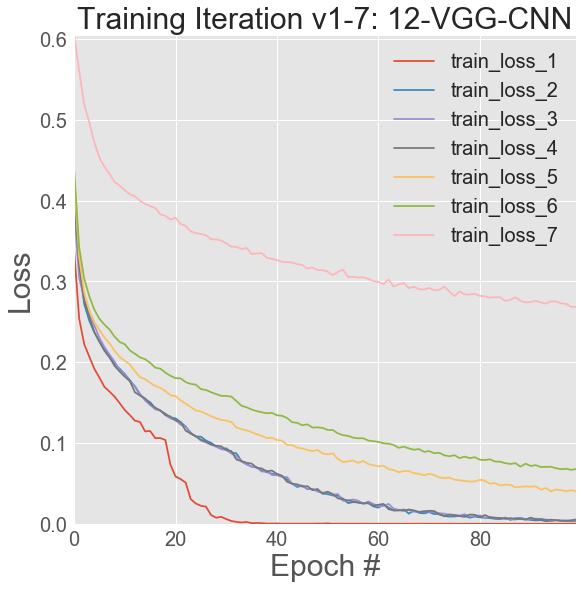

In [66]:
output_folder = os.path.join(os.path.expanduser("~"), 'Documents', 'figures', 
        'vers001-007_dnn')

# plot the training loss and accuracy
N = np.arange(0, loss.shape[1])
sns.set(font_scale=2)
plt.style.use("ggplot")
fontdict = {'fontsize': 32}

plt.figure(figsize=(9,9))
axes = plt.gca()
for idx in range(len(train_vers)):
    plt.plot(N, loss[idx,:], label="train_loss_{}".format(idx+1))
    plt.title("Training Iteration v1-7: 12-VGG-CNN", fontsize=30)
    plt.xlabel("Epoch #", fontsize=30)
    plt.ylabel("Loss", fontsize=30)
    plt.legend()
axes.autoscale(tight=True)
# plt.tight_layout()
figname=os.path.join(output_folder, 'loss.pdf')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
plt.savefig(figname, format='pdf')
plt.show()

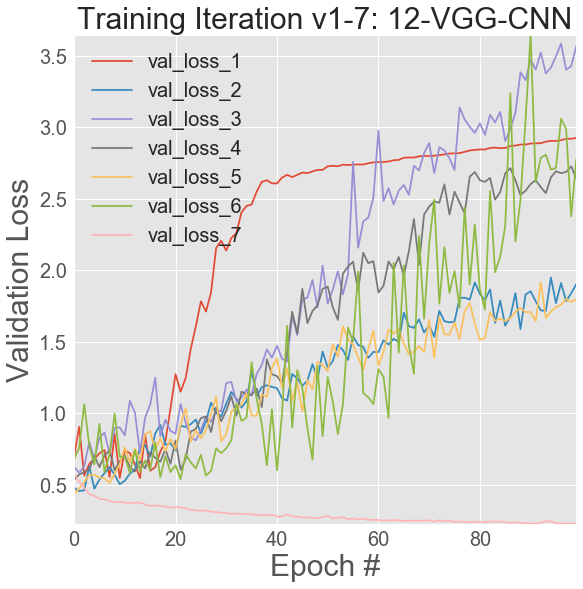

In [68]:
sns.set(font_scale=2)
plt.style.use("ggplot")

plt.figure(figsize=(9,9))
axes = plt.gca()
for idx in range(len(train_vers)):
    plt.plot(N, val_loss[idx,:], label="val_loss_{}".format(idx+1))
    plt.title("Training Iteration v1-7: 12-VGG-CNN", fontsize=30)
    plt.xlabel("Epoch #", fontsize=30)
    plt.ylabel("Validation Loss", fontsize=30)
    plt.legend()
axes.autoscale(tight=True)
# plt.tight_layout()
figname=os.path.join(output_folder, 'val_loss.pdf')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
plt.savefig(figname)
plt.show()

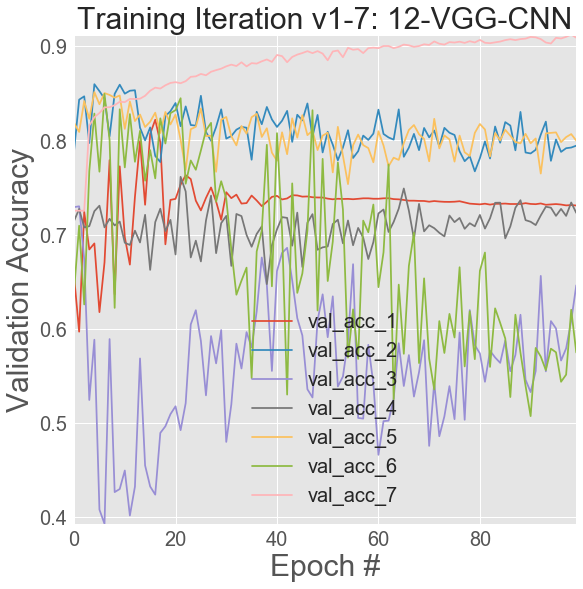

In [69]:
sns.set(font_scale=2)
plt.style.use("ggplot")

plt.figure(figsize=(9,9))
axes = plt.gca()
for idx in range(len(train_vers)):
    plt.plot(N, val_acc[idx,:], label="val_acc_{}".format(idx+1))
    plt.title("Training Iteration v1-7: 12-VGG-CNN", fontsize=30)
    plt.xlabel("Epoch #", fontsize=30)
    plt.ylabel("Validation Accuracy", fontsize=30)
    plt.legend()
axes.autoscale(tight=True)
# plt.tight_layout()

figname=os.path.join(output_folder, 'val_acc.pdf')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
plt.savefig(figname)
plt.show()


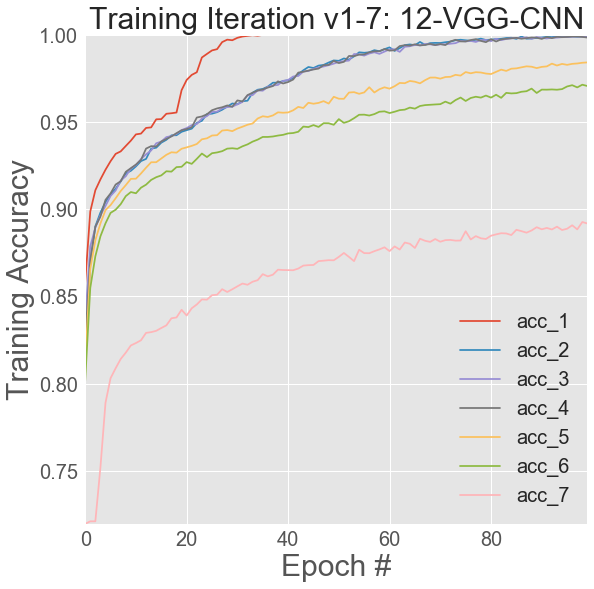

In [70]:
sns.set(font_scale=2)
plt.style.use("ggplot")

plt.figure(figsize=(9,9))
axes = plt.gca()
for idx in range(len(train_vers)):
    plt.plot(N, acc[idx,:], label="acc_{}".format(idx+1))
    plt.title("Training Iteration v1-7: 12-VGG-CNN", fontsize=30)
    plt.xlabel("Epoch #", fontsize=30)
    plt.ylabel("Training Accuracy", fontsize=30)
    plt.legend()
axes.autoscale(tight=True)
# plt.tight_layout()

figname=os.path.join(output_folder, 'acc.pdf')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
plt.savefig(figname)
plt.show()

# Load in Actual Experiments (exp001-005)

6/13/18: These were experiments done earlier this year in Feb on just loo procedure for analyzing patients based on different datasets and a leaky relu parameter change.

- exp001 = Loo baseline on real data
- exp002 = Loo with augmented dataset from id008/013
- exp003 = loo with augmented dataset (leaky relu)

In [90]:
output_folder = os.path.join(os.path.expanduser("~"), 'Documents', 'figures', 
        'exp001-005_dnn')
expname = 'exp003'
print(expname)
loss = np.zeros((len(patients), 300))
acc = np.zeros(loss.shape)
val_acc = np.zeros(loss.shape)
val_loss = np.zeros(loss.shape)

# go through all patients
for idx, pat in enumerate(patients):
    # real data results directory
    resultsdir = os.path.join('/Volumes/ADAM LI/pydata/', 'dnn/output/', expname, pat)
    resultfiles = [f for f in os.listdir(resultsdir) if f.endswith('.pkl')]
    
    # extract data from each training session
    for _file in resultfiles:
        histfile = os.path.join(resultsdir, _file)

        # load in the history file
        with open(histfile, "rb") as f:
            history = pickle.load(f)
        print(history.keys())
        print(len(history['loss']))
        
        loss[idx, :] = history['loss']
        acc[idx, :] = history['acc']
        val_acc[idx,:] = history['val_acc']
        val_loss[idx,:] = history['val_loss']

exp003
dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])
300
dict_keys(['acc', 'loss', 'val_loss', 'val_acc'])
300
dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])
300
dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])
300
dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])
300
dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])
300
dict_keys(['loss', 'acc', 'val_acc', 'val_loss'])
300


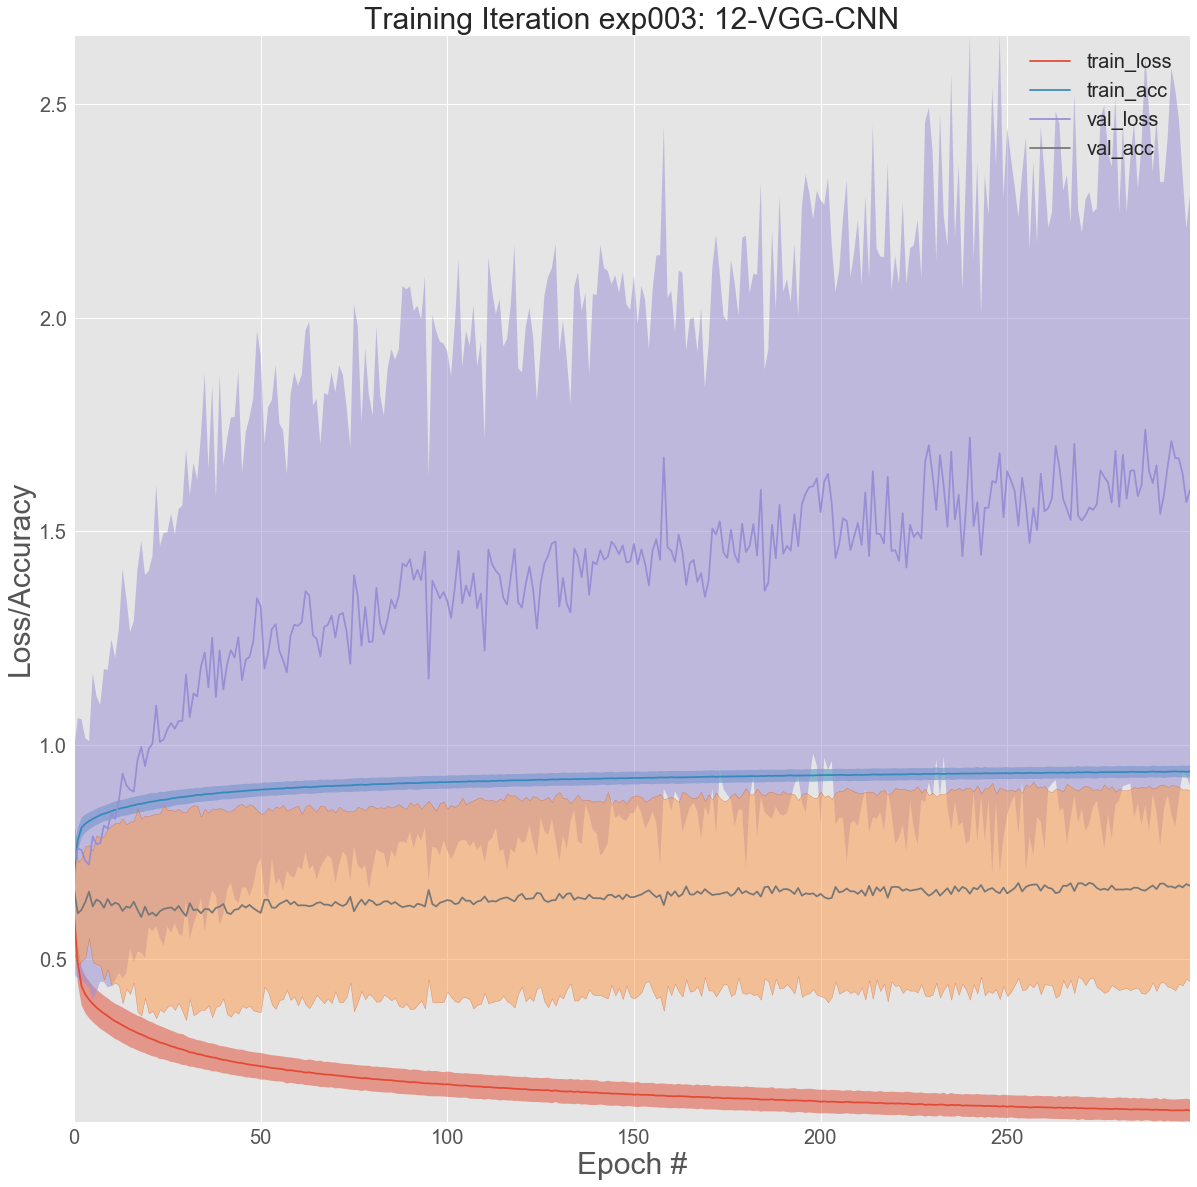

In [91]:
# plot the training loss and accuracy
N = np.arange(0, loss.shape[1])
sns.set(font_scale=2)
plt.style.use("ggplot")
fontdict = {'fontsize': 32}

# define mean and error region
all_loss = []
all_acc = []
all_val_loss = []
all_val_acc = []

plt.figure(figsize=(20,20))
axes = plt.gca()
for idx, pat in enumerate(patients):
    all_loss.append(loss[idx,:])
    all_acc.append(acc[idx,:])
    all_val_loss.append(val_loss[idx,:])
    all_val_acc.append(val_acc[idx,:])

y = np.mean(np.array(all_loss), axis=0)
error = np.std(all_loss, axis=0)
plt.plot(N, y, label="train_loss")
plt.fill_between(N, y-error, y+error, alpha=0.5)

y = np.mean(np.array(all_acc), axis=0)
error = np.std(all_acc, axis=0)
plt.plot(N, y, label="train_acc")
plt.fill_between(N, y-error, y+error, alpha=0.5)

y = np.mean(all_val_loss, axis=0)
error = np.std(all_val_loss, axis=0)
plt.plot(N, y, label="val_loss")
plt.fill_between(N, y-error, y+error, alpha=0.5)

y = np.mean(all_val_acc, axis=0)
error = np.std(all_val_acc, axis=0)
plt.plot(N, y, label="val_acc")
plt.fill_between(N, y-error, y+error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.title("Training Iteration {}: 12-VGG-CNN".format(expname), fontsize=30)
plt.xlabel("Epoch #", fontsize=30)
plt.ylabel("Loss/Accuracy", fontsize=30)
plt.legend()
axes.autoscale(tight=True)
# plt.tight_layout()
figname=os.path.join(output_folder, '.pdf'.format(expname))
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
plt.savefig(figname, format='pdf')
plt.show()

# Look At Pytorch Baselines For New TNG Datasets

- Instead of just 7 patients, we now have ~20 additional patients with a lot of data each. Processed with 5000 and 2500 sec win/step sizes on MFFT and Morlet Wavelet.

In [102]:
output_folder = os.path.join(os.path.expanduser("~"), 'Documents', 'figures', 
        'pytorch_baseline_dnn')
expname = 'pytorch_baseline'
print(expname)
patients = [
        'id001_bt',
    'id002_sd',
#     'id003_mg',
    'id004_bj', 'id005_ft',
    'id006_mr', 'id007_rd', 'id008_dmc',
    'id009_ba', 'id010_cmn', 'id011_gr',
    'id013_lk', 'id014_vc', 'id015_gjl',
    'id016_lm', 'id017_mk', 'id018_lo', 'id020_lma']

loss = np.zeros((len(patients), 100))
acc = np.zeros(loss.shape)
val_acc = np.zeros(loss.shape)
val_loss = np.zeros(loss.shape)

val_metrics = train_metrics = {
    'loss': np.zeros(loss.shape),
    'accuracy': np.zeros(loss.shape),
    'precision': np.zeros(loss.shape),
    'recall': np.zeros(loss.shape),
    'fp': np.zeros(loss.shape),
}
patlist = []
# go through all patients
for idx, pat in enumerate(patients):
    # real data results directory
    resultsdir = os.path.join('/Volumes/ADAM LI/pydata/dnn/output/', expname, pat,
                             'output')
    resultfiles = [f for f in os.listdir(resultsdir) if f.endswith('.pkl')]
    
    # extract data from each training session
    for _file in resultfiles:
        histfile = os.path.join(resultsdir, _file)

        # load in the history file
        with open(histfile, "rb") as f:
            history = pickle.load(f)
        valhistory = history['val']
        trainhistory = history['train']
#         print(history.keys())
#         print(trainhistory.keys())
#         print(len(trainhistory['loss']))
        
        for key, item in trainhistory.items():
            if key == 'epoch':
                continue
            train_metrics[key][idx,:] = item
        for key, item in valhistory.items():
            if key == 'epoch':
                continue
            val_metrics[key][idx,:] = item
        patlist.append(pat)
#         loss[idx, :] = trainhistory['loss']
#         acc[idx, :] = trainhistory['accuracy']
        
        
#         val_acc[idx,:] = valhistory['accuracy']
#         val_loss[idx,:] = valhistory['loss']

pytorch_baseline


loss
accuracy
precision
recall
fp


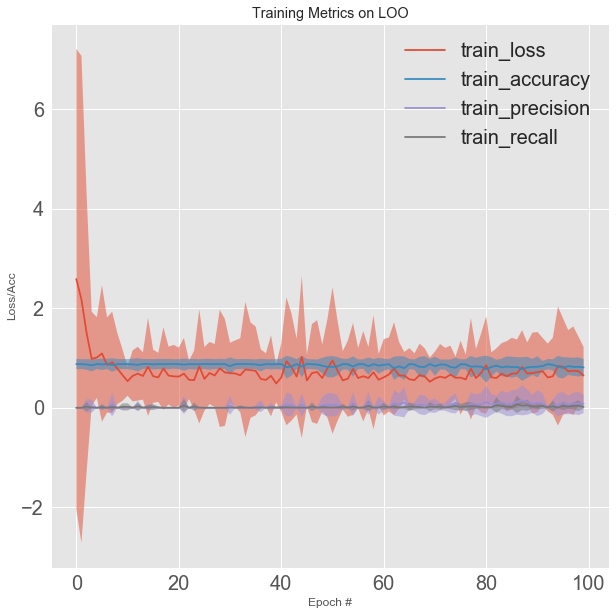

In [110]:
# plot the training loss and accuracy
N = np.arange(0, train_metrics['loss'].shape[1])
sns.set(font_scale=2)
plt.style.use("ggplot")
fontdict = {'fontsize': 32}

plt.figure(figsize=(10,10))
axes = plt.gca()
for key,item in train_metrics.items():
    print(key)
    if key == 'fp':
        continue
        
    y = np.mean(item, axis=0)
    error = np.std(item, axis=0)
    plt.plot(N, y, label="train_{}".format(key)) #patlist[ipat])
    plt.fill_between(N, y-error, y+error, alpha=0.5)
#     for ipat in range(item.shape[0]):
#         plt.plot(N, item[ipat,:], label=patlist[ipat])
plt.title('Training Metrics on LOO')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Acc')
plt.legend()
plt.show()